In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize
import corner
import scipy.io as sp_io
import scipy.integrate as sp_int
import importlib
import torus
#importlib.reload(torus)
from copy import deepcopy
from astropy.io import fits


KeyError: 'XUVTOP'

In [2]:
smith_data = pd.read_excel('he_ew_smith_table1.xlsx', usecols = [0, 1, 2, 4, 6], names = ['Star', 'EW', 'log(Lx/Lbol)', 'logRhk', 'B-V'])

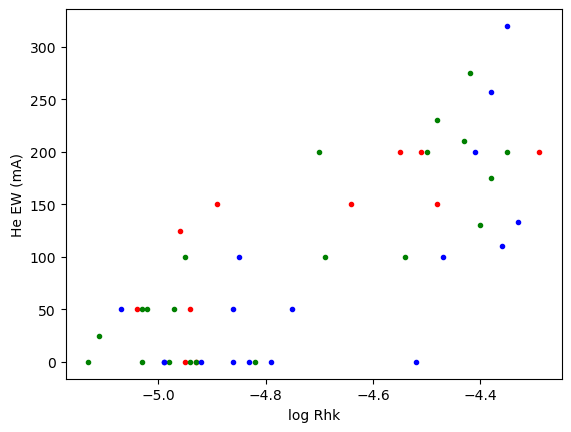

In [5]:
smith_dataK = smith_data[smith_data['B-V'] > 0.81]
smith_dataG = smith_data[(smith_data['B-V'] > 0.58) & (smith_data['B-V'] < 0.81)]
smith_dataF = smith_data[(smith_data['B-V'] > 0.30) & (smith_data['B-V'] < 0.58)]


plt.plot(smith_dataK['logRhk'], smith_dataK['EW'],  'r.', label = 'K')
plt.plot(smith_dataG['logRhk'], smith_dataG['EW'],  'g.', label = 'G')
plt.plot(smith_dataF['logRhk'], smith_dataF['EW'], 'b.', label = 'F')
plt.xlabel('log Rhk')
plt.ylabel('He EW (mA)')
plt.savefig('smithRhkcoded.pdf')

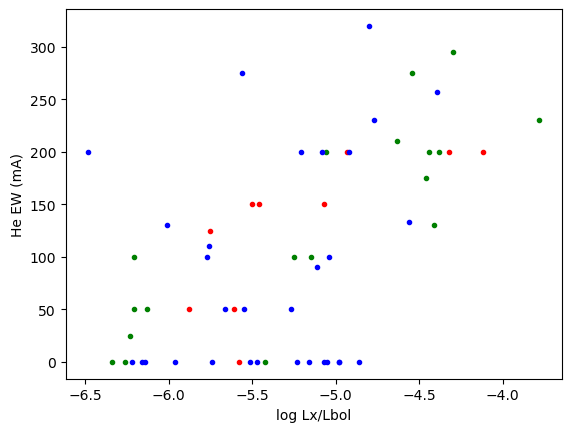

In [6]:
plt.plot(smith_dataK['log(Lx/Lbol)'], smith_dataK['EW'], 'r.', label = 'K')
plt.plot(smith_dataG['log(Lx/Lbol)'], smith_dataG['EW'], 'g.', label = 'F')
plt.plot(smith_dataF['log(Lx/Lbol)'], smith_dataF['EW'], 'b.', label = 'G')
plt.xlabel('log Lx/Lbol')
plt.ylabel('He EW (mA)')
plt.savefig('smithLxcoded.pdf')

In [8]:
#table without nans

smith_data_noNAN = smith_data[smith_data['logRhk'].notna()]


x = smith_data_noNAN['logRhk'].values
y = smith_data_noNAN['EW'].values
yerr = np.ones(len(x)) * 40

Least-squares estimates:
m = 259.224 ± 21.110
b = 1323.312 ± 100.205


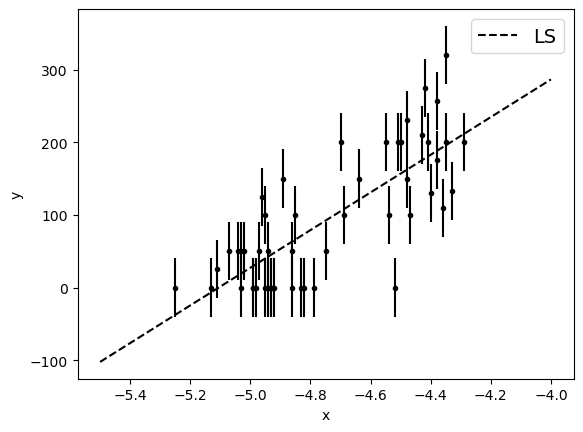

In [9]:
A = np.vander(x, 2)
C = np.diag(yerr * yerr)
ATA = np.dot(A.T, A / (yerr**2)[:, None])
cov = np.linalg.inv(ATA)
w = np.linalg.solve(ATA, np.dot(A.T, y / yerr**2))
print("Least-squares estimates:")
print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
x0 = np.linspace(-5.5, -4, 500)
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k", label="LS")
plt.legend(fontsize=14)
plt.xlabel("x")
plt.ylabel("y");

In [10]:
#make a quick mcmc in order to find a straight line fit of the points

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr**2 + model**2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model)**2 / sigma2 + np.log(sigma2))

def log_prior(theta):
    m, b, log_f = theta
    return 0.0

def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

Maximum likelihood estimates:
m = 237.598
b = 1219.075
f = 0.380


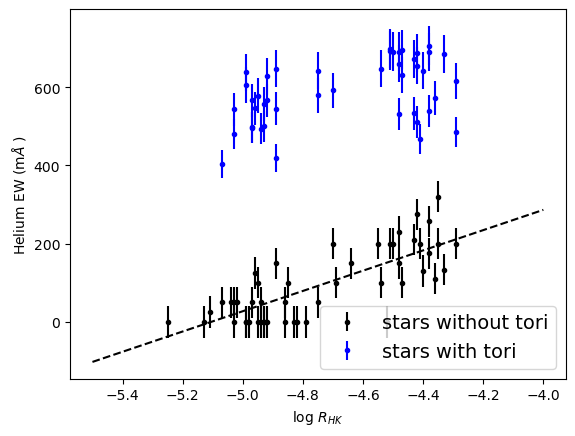

In [29]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args)
initial = np.array([w[0], w[1], 1]) + 0.1 * np.random.randn(3)
soln = minimize(nll, initial, args=(x, y, yerr))
m_ml, b_ml, log_f_ml = soln.x

print("Maximum likelihood estimates:")
print("m = {0:.3f}".format(m_ml))
print("b = {0:.3f}".format(b_ml))
print("f = {0:.3f}".format(np.exp(log_f_ml)))

plt.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0, label = 'stars without tori')
plt.errorbar(samples['logRhk'], samples['EWp'] - 300, yerr=samples['EWp']*0.05, fmt=".b", capsize=0, label = 'stars with tori') #synthetic data
plt.plot(x0, np.dot(np.vander(x0, 2), w), "--k") #,label="LS")
#plt.plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML")
plt.legend(fontsize=14)
plt.ylabel(r"Helium EW (m$\AA~$)")
plt.xlabel(r"log $R_{HK}$");
#plt.savefig('tori.pdf')

In [12]:
pos = soln.x + 1e-4 * np.random.randn(32, 3)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True);


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:05<00:00, 898.84it/s]


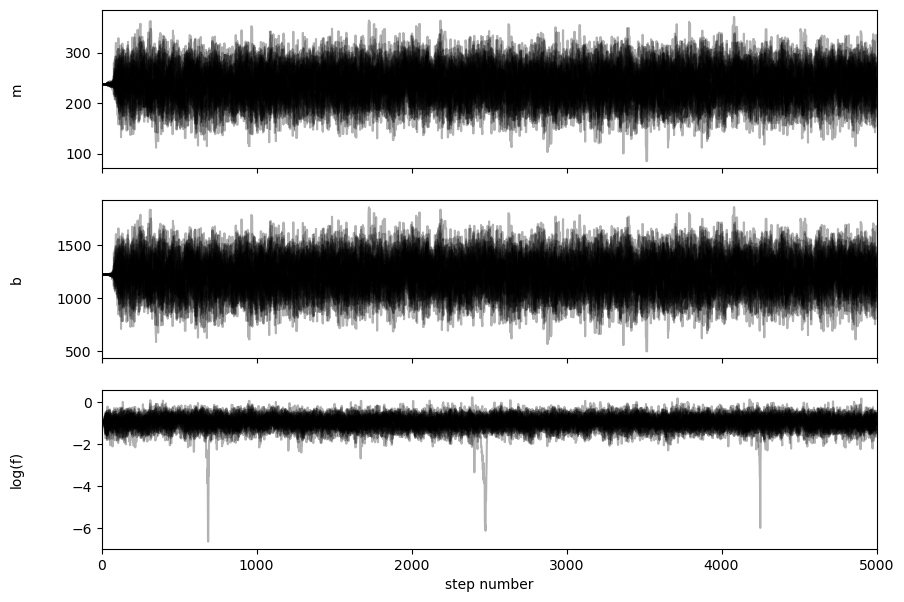

In [13]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["m", "b", "log(f)"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [11]:
tau = sampler.get_autocorr_time()
print(tau)

[36.99796526 36.96818931 36.61483497]


In [12]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
print(flat_samples.shape)

(10432, 3)


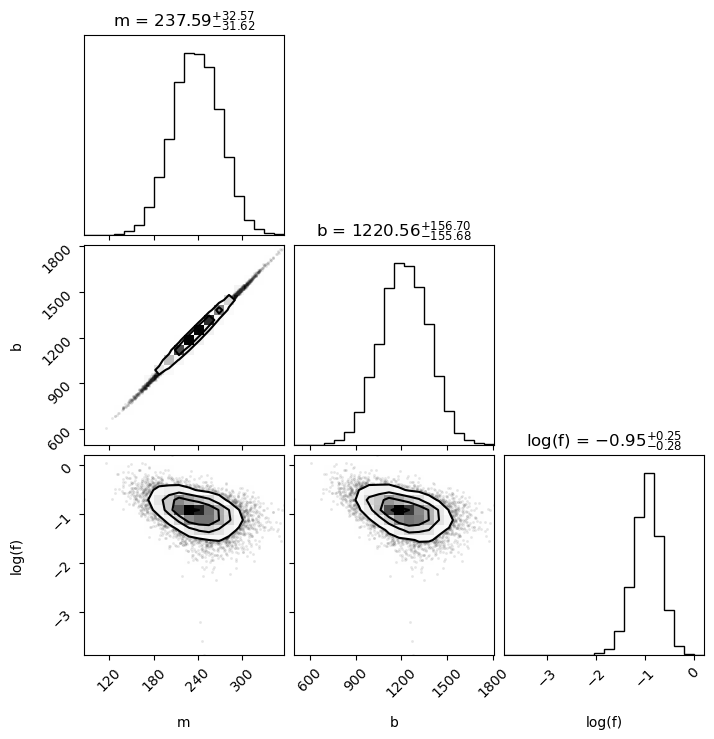

In [13]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, show_titles=True
);

In [ ]:
#taking the maximum likelihood estimates for a straight line through the points, create histogram of distances

def rms(theta, x, y, yerr = 1):

    m, b, log_f = theta
    model = m * x + b
    dist = (y - model)**2 / yerr**2
    return dist

plt.hist(rms(soln.x, x, y, yerr))
plt.hist(rms(soln.x, samples['logRhk'], samples['EWp'], yerr= samples['EWp']*0.1))
plt.savefig('torihist.pdf')


In [17]:
#steps

#1) randomly draw 50 samples to get a new data set of EW, log(Lx/Lbol) and logRHk
m = 50

samples = smith_data_noNAN.sample(n=m, replace=True)
samples = samples.drop(columns=['Star', 'B-V'])

#2) for each sample randomly draw a stellar type, stellar mass and bolometric luminosity (these will be related)

#Use mass-luminosity relation:

#L/L_sun = (M/M_sun)^4 which is applicable in between 0.43 and 2 solar mass (source wikipaedia-need to find actual reference)

#K mass: 0.45 - 0.8, #G mass: 0.8-1.04, #F mass: 1.04-1.4 (source wikipaedia-need to find actual reference)

mass = np.random.default_rng().uniform(0.45, 1.4, m) 
radius = 0.89 * mass**0.89
Lbol = mass**4   #do I want to draw in mass space or luminosity space (and how do I want to do these draws)
type = ['K' if m < 0.8 else 'G' if m < 1.04 else 'F' for m in mass] 

samples['mass'] = mass
samples['radius'] = radius
samples['Lbol'] = Lbol
samples['type'] = type

#calculate LEUV using LX-LEUV relations

#for now just use LEUV = 100 LX

samples['LEUV'] = samples['Lbol'] * 100 * 10**samples['log(Lx/Lbol)']

#3) for each sample draw planet orbital period (this currently only effects the size of the disc)

period = np.random.default_rng().uniform(1, 3, m)

samples['period'] = period


#4) run through EW calculator to find new equivalent equivalent width

EWwithplanet = []
for index, star in samples.iterrows():

    a = (G * star['mass'] * 2e33 * (star['period'] * 60 * 60 * 24)**2 / (4 * np.pi**2))**(1/3)
    FEUV = star['LEUV'] *  3.8e33 / (4 * np.pi * a**2)
    spec = normalize_spectrum(ss, FEUV)
    torus1 = torus.Torus({'h': 1, 'he' : 0.11}, spec, star['mass'] * 2e33, star['radius'] * 7e10, a, 10**4, a, tau = 1)
    torus1.calculate_ion_abundances_all_species()
    EW = torus1.get_EW()
    EWwithplanet.append(EW)

samples['EWp'] = EWwithplanet

#need to consider the initial spectral shape of the helium line 

0.1364920437335968
(312, 400)
0.0014088148018345237
(312, 400)
0.37238919734954834
(312, 400)
0.004748662002384663
(312, 400)
0.0009039882570505142
(312, 400)
0.14521479606628418
(312, 400)
0.01862986385822296
(312, 400)
0.41718047857284546
(312, 400)
0.0446031279861927
(312, 400)
0.0003806808963418007
(312, 400)
1.2444372177124023
(312, 400)
0.03497224301099777
(312, 400)
0.004810664802789688
(312, 400)
0.24009449779987335
(312, 400)
0.004441443830728531
(312, 400)
0.27526307106018066
(312, 400)
0.006955502554774284
(312, 400)
0.002976581919938326
(312, 400)
nan
(312, 400)
0.0003313890192657709
(312, 400)
nan
(312, 400)
0.021501697599887848
(312, 400)
0.005640576593577862
(312, 400)
0.017717648297548294
(312, 400)
nan
(312, 400)
0.052072733640670776
(312, 400)
0.09301254153251648
(312, 400)
0.05460225045681
(312, 400)
nan
(312, 400)
0.07417947798967361
(312, 400)
0.812669038772583
(312, 400)
0.03322836756706238
(312, 400)
0.03508628532290459
(312, 400)
0.013637227937579155
(312, 400)


In [31]:
samples

,EW,log(Lx/Lbol),logRhk,mass,radius,Lbol,type,LEUV,period,EWp
50,0,-5.05,-4.92,1.379193,1.184831,3.618268,F,0.003225,1.925738,834.390607
57,50,-6.13,-5.03,0.692422,0.641683,0.229871,K,0.000017,2.792074,823.653944
22,275,-4.54,-4.42,0.559089,0.530455,0.097707,K,0.000282,1.318974,948.169261
19,0,-5.96,-4.79,1.035483,0.918052,1.149665,G,0.000126,1.274547,734.942869
68,0,NaN,-5.03,0.718551,0.663189,0.266582,K,NaN,2.075778,NaN
59,50,NaN,-5.02,0.929453,0.833897,0.746292,G,NaN,2.320567,NaN
44,0,-4.98,-4.99,0.968265,0.864818,0.878975,G,0.000920,2.576707,988.191458
27,230,-3.78,-4.48,1.174426,1.026916,1.902405,F,0.031572,2.791920,1008.691874
25,0,-6.14,-4.52,0.715401,0.660601,0.261938,K,0.000019,1.341858,772.881428
27,230,-3.78,-4.48,1.350047,1.162520,3.321966,F,0.055131,1.017727,653.832799


In [ ]:
for i in samples:
    print(i['mass'])

In [28]:
EWwithplanet

[811.4244891563786,
 916.0722379682743,
 805.9251401581226,
 972.1415505233003,
 949.421980526741]

In [15]:
#constants 

c = 2.9979e10
mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [16]:
##turn .sav file of solar spectrum into usable python solar spectrum 
"""** Structure <20abc08>, 6 tags, length=165722064, data length=165722064, refs=1:
   WAVELENGTH      FLOAT     Array[920]			(nm)
   DATE_YD         DOUBLE    Array[14989]		(YYYYDOY date format)
   DATE_JD         DOUBLE    Array[14989]		(Julian Day format)
   IRRADIANCE      FLOAT     Array[14989, 920]	(mW/m^2/nm)
   FLAG_SOURCE     FLOAT     Array[14989, 920]	(number from -1 to 139 that represents data source)
   MODEL           FLOAT     Array[14989, 920]	(mW/m^2/nm)
   UNCERTAINTY_IRRADIANCE   FLOAT     Array[920]    (unitless, % relative accuracy)
   UNCERTAINTY_MODEL        FLOAT     Array[920]    (unitless, % relative accuracy)"""



ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH'] * 1e-8       #in angstroms so turn into cgs 
    irr_wav = spec['FLUX'] * 1e8          
    nu = c / wav
    irr_nu = irr_wav * wav**2 / c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}


K6 = get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')
K2 = get_spectra('hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits')
G5 = get_spectra('hlsp_muscles_multi_multi_wasp-127_broadband_v24_adapt-const-res-sed.fits')
F4 = get_spectra('hlsp_muscles_multi_multi_wasp-43_broadband_v24_adapt-const-res-sed.fits')


def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

norm_ss = normalize_spectrum(ss, 10**4)

In [ ]:
testTorus = torus.Torus({'h': 1, 'he' : 0.11}, norm_ss, 1e33, 7e10, 0.02*1.5e13, 10**4, 0.02*1.5e13, tau = 1)

In [ ]:
testTorus.calculate_ion_abundances_all_species()
testTorus.get_EW()

In [ ]:
(5 & 1) == 1

In [ ]:
K6['wl']

In [ ]:
normalize_spectrum(K6, 10**4)